In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
# import corner
# import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
# from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:

# len(calib['So'].join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi']]).dropna())

In [4]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'PGC1', 'Nest',
       'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel', 'Vls', 'v3k', 'f',
       'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc', 'g***', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE', 'GLong', 'GLat', 'SGL', 'SGB',
       'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg', 'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10154


,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [5]:
df['Vmod'] = df.fg*df.V3kg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
len(df)

10154

In [7]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [8]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flux
PGC,
2,4.73
4,1.85
6,NaN
12,3.40
16,1.19


In [9]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"v3k":"V3k"})

df.head()

,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,34.110800,NaN,NaN,NaN,NaN,-22.220800,NaN,NaN,NaN,4.73
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,33.717130,-18.127130,-18.387130,-18.597130,-18.647130,-17.647130,0.47,1.96,0.07,1.85
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,34.613753,NaN,NaN,NaN,NaN,-21.023753,NaN,NaN,NaN,3.40
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,34.298275,-19.938275,-20.438275,-20.718275,-20.898275,-20.308275,0.78,NaN,NaN,1.19
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,33.894347,-18.364347,-18.574347,-18.674347,-18.724347,-17.694347,0.31,NaN,NaN,4.30


In [10]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

<ipython-input-10-dd05b02ea261>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-10-dd05b02ea261>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


In [11]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10154

In [12]:
df.head()

,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux,F21_av
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,NaN,NaN,NaN,NaN,-22.220800,NaN,NaN,NaN,4.73,4.730
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,-18.127130,-18.387130,-18.597130,-18.647130,-17.647130,0.47,1.96,0.07,1.85,1.905
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,NaN,NaN,NaN,NaN,-21.023753,NaN,NaN,NaN,3.40,3.400
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,-19.938275,-20.438275,-20.718275,-20.898275,-20.308275,0.78,NaN,NaN,1.19,1.190
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,-18.364347,-18.574347,-18.674347,-18.724347,-17.694347,0.31,NaN,NaN,4.30,4.300


In [13]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536, 21102,50073, 5896, 15345] 
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

print(len(calib))

calib = calib.join(df[["V3k", "Vmod", "Qw", "F21", 'eF21', 'elgWi']]).dropna()

print(len(calib))


calib = calib[(calib.Qw>2) & (calib['W1']>0)]

print(len(calib))

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)

calib['M1'] = calib.W1-calib.dm19
gamma = np.log10(0.5) + 0.4*5.91
calib['logMs_W1'] = gamma - 0.4*calib['M1']
calib['Ms_W1'] = 10**calib.logMs_W1

# calib = calib[calib.M1<-16.1]

calib = calib.dropna()


print(len(calib))
calib.head(5)

94
81
80
80


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,Vmod,Qw,F21,eF21,elgWi,Dist,Mass_HI,M1,logMs_W1,Ms_W1
PGC,,,,,,,,,,,,,,,,,,,,,
1014,2,NGC0055,26.507,84,2.222,0.034,0.0,0.0,0.0,0.0,...,-127.000,5.0,9.690,342.49,0.034,2.001705,9.147429e+06,-18.467,9.44977,2.816891e+09
2758,2,NGC0247,27.729,73,2.331,0.013,0.0,0.0,0.0,0.0,...,20.000,5.0,687.380,137.38,0.013,3.513986,1.999734e+09,-18.709,9.54657,3.520222e+09
3238,2,NGC0300,26.444,53,2.244,0.063,0.0,0.0,0.0,0.0,...,-90.000,5.0,664.340,283.56,0.063,1.944464,5.917874e+08,-18.194,9.34057,2.190635e+09
9332,2,NGC0925,29.840,56,2.377,0.021,0.0,0.0,0.0,0.0,...,309.309,5.0,251.635,0.15,0.023,9.289664,5.116186e+09,-19.670,9.93097,8.530412e+09
13179,2,NGC1365,31.372,55,2.656,0.026,0.0,0.0,0.0,0.0,...,1413.632,5.0,146.450,24.95,0.026,18.810485,1.220857e+10,-22.672,11.13177,1.354472e+11


In [14]:
calib.groupby("So").count()

# So = 2 : Both
# So = 0 : CPLR
# So = 1 : TRGB

print(len(calib))

80


In [15]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [16]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

alfa = 0.4356745719231558 
beta = 1.5772902772798747

df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
df['Ms_i'] = 10**df.logMs_i

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df["logMs_i"][df.Qs==0]=np.nan
df["logMs_W1"][df.Qw==0]=np.nan

df["logMs_av"] = df[["logMs_i", "logMs_W1"]].mean(axis=1)

df[["logMs_av", "logMs_i", "logMs_W1", "i***", "w1***", "Qs", "Qw"]].head()

<ipython-input-16-e4286077c8a0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logMs_i"][df.Qs==0]=np.nan
<ipython-input-16-e4286077c8a0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logMs_W1"][df.Qw==0]=np.nan


,logMs_av,logMs_i,logMs_W1,i***,w1***,Qs,Qw
PGC,,,,,,,
2,10.951290,NaN,10.951290,NaN,11.89,NaN,5.0
4,9.171366,9.220909,9.121822,15.12,16.07,5.0,4.0
12,10.472471,NaN,10.472471,NaN,13.59,NaN,5.0
16,10.195353,10.204427,10.186280,13.58,13.99,5.0,5.0
55,9.161399,9.182088,9.140709,15.22,16.20,5.0,4.0


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Gass Fraction   $[M_g/(M_g+M_*)]$')

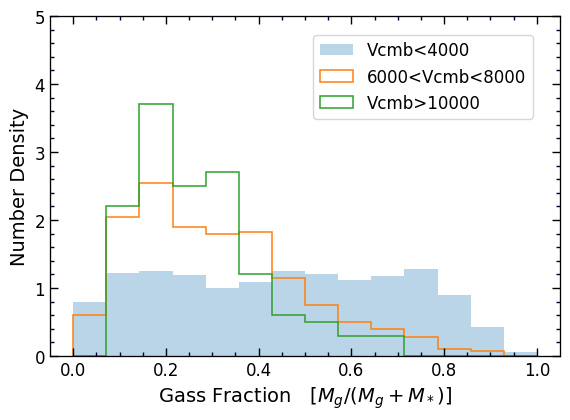

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

df['Mgass'] = 1.33*(10**(np.log10(df.Mass_HI)))
df['Mb'] = df.Ms_i + df.Mgass
df['fraction'] = df.Mgass / df.Mb

bins=np.linspace(0,1,15)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k<4000)]
x = dff.fraction.values
ax.hist(x, alpha=0.3, density=True, label='Vcmb<4000', lw=1.1, bins=bins)


dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>6000)&(df.V3k<8000)]
x = dff.fraction.values
ax.hist(x, alpha=0.99, density=True, label='6000<Vcmb<8000', lw=1.1, histtype='step', bins=bins)


dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>10000)]
x = dff.fraction.values
ax.hist(x, alpha=0.99, density=True, label='Vcmb>10000', lw=1.1, histtype='step', bins=bins)

# dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>15000)]
# x = dff.fraction.values
# ax.hist(x, alpha=0.5, density=True)

ax.legend(bbox_to_anchor=(0.5, 0.97), loc='upper left', fontsize=12)

x_ax, y_ax = set_axes(ax, [-0.05,1.05], [0,5], fontsize=12, inout='in')


ax.set_ylabel('Number Density', fontsize=14) 
ax.set_xlabel('Gass Fraction   ' + r'$[M_g/(M_g+M_*)]$', fontsize=14)


Text(0.5, 1.0, 'Gass Fraction')

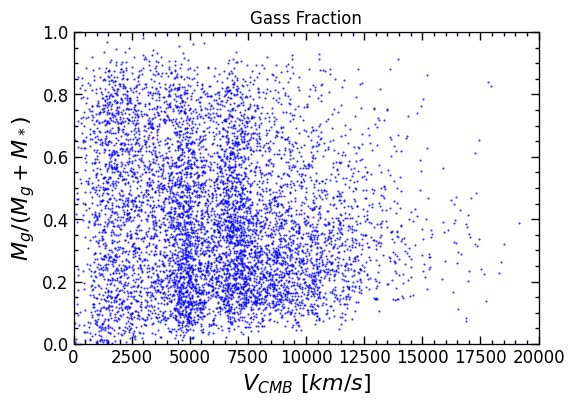

In [18]:
from matplotlib.pyplot import figure

fig = py.figure(figsize=(5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>0)]
x = dff.V3k
y = dff.fraction

ax.plot(x, y, 'ko', alpha=0.8, ms=1.5, mfc='b', mec='none') 

set_axes(ax, (0,20000), (0,1), fontsize=12)


ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=16) 
ax.set_ylabel(r'$M_g/(M_g+M_*)$', fontsize=16)
ax.set_title('Gass Fraction')

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b9c4a9e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b9c4d78b0>)

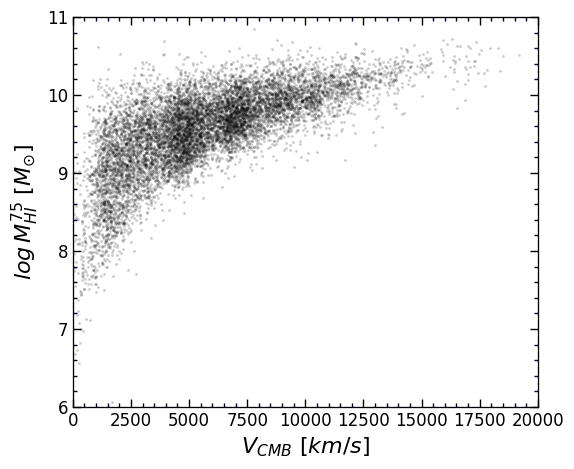

In [19]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

M_HI = np.log10(df['Mass_HI'])
V3k = df.V3k.values

# ax.plot(V3k, M_HI, 'k.', alpha=0.03)
ax.plot(V3k, M_HI, 'ko', alpha=0.20, ms=2, mfc='k', mec='none') 

ax.set_ylabel(r'$log \/M^{75}_{HI} \/\/ [M_{\odot}]$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (6,11), fontsize=12)

iter:  0
iter:  1


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-db0481f58e62>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-20-db0481f58e62>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-20-db0481f58e62>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy

Text(1.7650000000000001, 11.600000000000001, '$W1-band$')

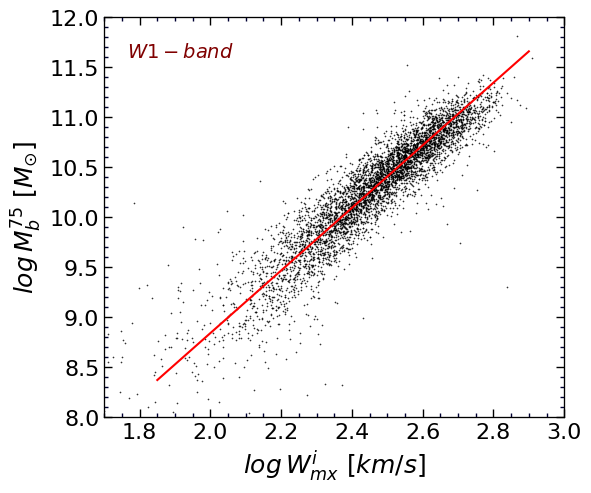

In [20]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>0)]

  


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values



fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

# ax.plot(logW, logMass, 'k.', alpha=0.05) 
ax.plot(logW, logMass, 'ko', alpha=0.8, ms=1.2, mfc='k', mec='none') 



    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

# ax.set_title("W1-band", fontsize=16)


dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.0*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    
w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'r-')

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r"$W1-band$", fontsize=14, color='maroon')

In [21]:
len(df)

10154

2.3864461031893835 -5.115425138587878


<ipython-input-22-76852135bb8d>:7: RuntimeWarning: divide by zero encountered in log10
  Y0 = dff.logMs_av.values-np.log10(dff.Mass_HI.values)


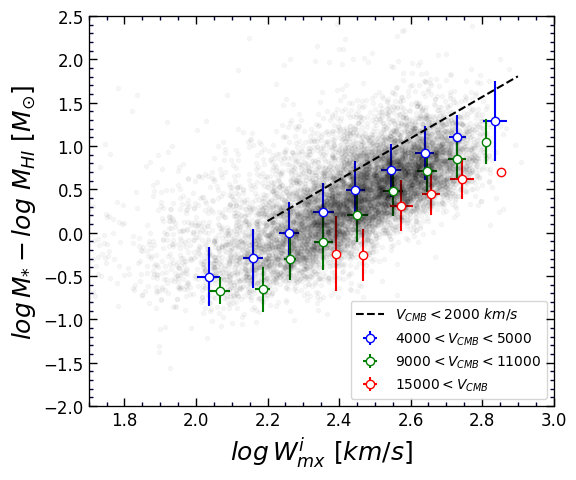

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[((df.Qw>2)|(df.Qs>2))&(df.elgWi>0)&(df.lgWmxi>0)]
X0 = dff.lgWmxi.values
Y0 = dff.logMs_av.values-np.log10(dff.Mass_HI.values)
V3k = dff.V3k.values
# Y0 = Y0 - (mc*V3k+bc)

ax.plot(X0, Y0, 'k.', alpha=0.03)
# ax.plot(X0, Y0, 'ko', alpha=0.05, ms=3.5, mfc='k', mec='none') 


label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V_{CMB}<11000$'
lab = True
ind, = np.where((V3k>9000)&(V3k<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V_{CMB}$'
lab = True      
ind, = np.where((V3k>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3.0,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}-log \/\/ M_{HI} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (-2,2.5), fontsize=12)




x = np.linspace(2.2, 2.9, 100)
ind, = np.where((X0>2.2)&(dff.V3k>0)&(dff.V3k<2000)&(X0<2.9))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k', label=r'$V_{CMB}<2000 \/\/ km/s$')

print(m,b)
# m = 2.3548648770909377 
# b = -5.000227567400469

ax.legend()

/home/ehsan/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3323: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


-5.515999981217281e-05 [[5.90559998e-07]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b8c50cee0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b8c64cd30>)

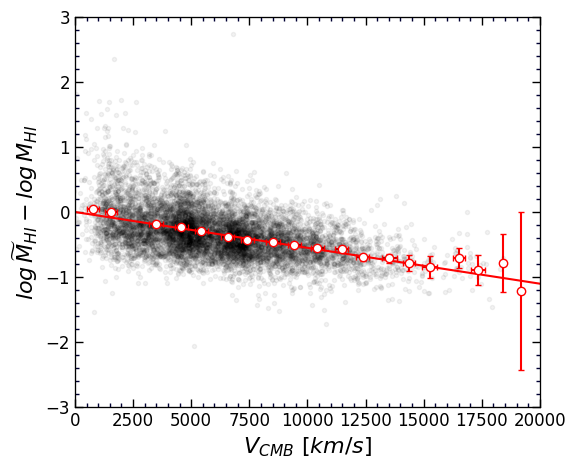

In [23]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = V3k

X = X[X0>2.2]
Y = Y[X0>2.2]
ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        
        N = len(xp)
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.mean(yp)/np.sqrt(N), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe, capsize=2) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
mc = fit[0] #; bc=fit[1]
ax.plot(x, mc*x, '-', color='r')
print(mc, np.sqrt(cov))

# ff, cov = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2, cov=True)
# x = np.linspace(0,5000,1000)
# y = x*0.
# n = len(ff)
# for i in range(n):
#     y += ff[i]*x**(n-i-1)

    
# ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log \/\widetilde{M}_{HI}  - log\/ M_{HI}$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

# ax.ticklabel_format(useMathText=True)

In [24]:
def HI_corrector(mc, bc, V3k):
    
    return mc*V3k+bc
#     return 0.*V3k

In [25]:
PGC_outlier_1 = [    356,    1286,    1553,    2080,    2266,    2768,    3084,
          3174,    3235,    3717,    3763,    5043,    6054,    6438,
          6966,    6982,    9399,   15460,   21673,   22381,   23355,
         27640,   30358,   32707,   35942,   36349,   36466,   42938,
         43726,   45887,   50012,   51450,   53728,   66948,   67511,
         69016,   83427,   84490,   90431,   90844,   91252,  142838,
        142840,  169737, 4310833, 5057394, 5057398]

PGC_outlier_2 = [   2712,    3081,    3133,    3247,    4387,    6889,    9134,
         36778,   53291,   70708,   71795,   85607,  138562,  142824,
        169989,  170138, 1056132, 1129847, 5076801]


In [26]:
len(calib)

80

iter:  0
iter:  1
3.31688912524737 10.320280407985637


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-27-c2f3297881c5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-27-c2f3297881c5>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-27-c2f3297881c5>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy

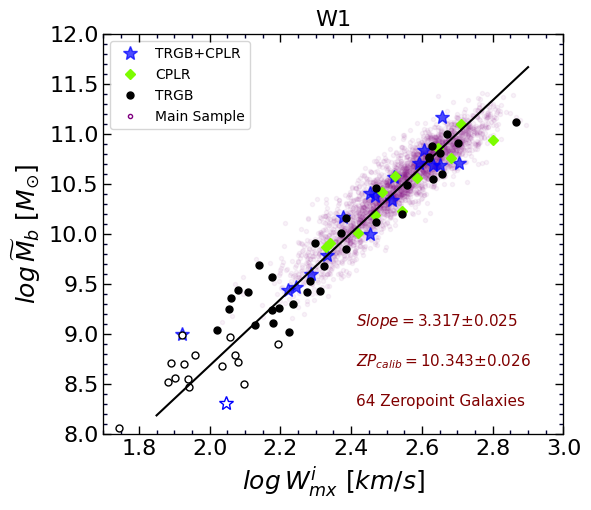

In [27]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_W1 + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)



dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_W1.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), dlogMb*0.+0.01, clip=3.)
    
    dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    



fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
MM = calib.M1.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

Y = Y - zp_calib + b0
zp_calib += 0.016


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='purple', alpha=0.05) 
# ax.plot(logW, logMass, '.', color='purple', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='purple', label='Main Sample', mfc='white') 
#######################################################################


# ID = dff.index.values
# for i in range(len(ID)):
#     if ID[i] in PGC_outlier_1:
#         ax.plot([logW[i]], [logMass[i]], 'r.', alpha=0.5)
#     if ID[i] in PGC_outlier_2:
#         ax.plot([logW[i]], [logMass[i]], 'b.', alpha=0.5)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-')
# ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}^{75}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
# ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("W1", fontsize=16)



# X = logW
# Y = logMass
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='magenta', ms=6, mfc='white')   
        
# for i in np.arange(8,12,0.5):
#     xp = []
#     yp = []
#     for ii in range(len(Y)):
#         xi = Y[ii]
#         if xi>=i and xi<i+0.5:
#             xp.append(xi)
#             yp.append(X[ii])
#     if len(xp)>0:
#         ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
#                     color='r', ms=6)  
        
        
# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')



x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[MM<-16.1])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

# ax.legend(bbox_to_anchor=(0.65, 0.50), loc=2)

# ax.plot([2.5,2.5], [8, b0], 'k:')
# ax.plot([0,2.5], [b0, b0], 'k:')

In [28]:
std

0.17172205021572298

In [29]:
np.std(Y[(Y<11.5)&(Y>8.9)] - (m0*(X[(Y<11.5)&(Y>8.9)]-2.5) + zp_calib))

0.23384820575690193

In [30]:
m0, b0

(3.31688912524737, 10.320280407985637)

In [ ]:
b0 = zp_calib

819
290
8


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-31-9f9ede108085>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


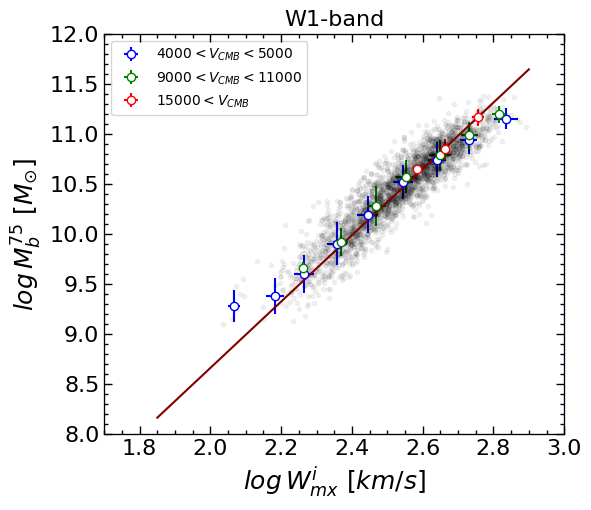

In [31]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{CMB}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{CMB}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("W1-band", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [32]:
def getDM(mag, Wlog, F21, m0, b0, D, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [33]:
dff = df[(df.Qw>0)&(df.elgWi>0)&(df.lgWmxi>0)]
mag = dff["w1***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values

N = len(dff)
M1_fid = np.zeros(N)
pp=0

for j in range(N):
    mag_ = mag[j]

    D = np.arange(0.5,800,0.5)
    delta = D*0.
    
    for i in range(len(D)):
        delta[i] =  D[i] - getDM(mag[j], Wlog[j], F21[j], m0, b0, D[i], V3k[j])
    


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

    try:
#         D_left = np.max(D[delta<0])
#         D_right = np.min(D[delta>0])
#         D_root = 0.5*(D_left+D_right)
        D_root = interpol(D, delta)
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid
    except:
        D_root = np.max(D[delta<0])
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ - DM_fid    
        print("flag (j, pgc): ", j, PGC[j])
        pp+=1
    if j%1000==0:
        print(j)
        
    if PGC[j]==1781:
        print(j, mag_, DM_fid, D_root)

print("Number of concerning distances:", pp)

<ipython-input-32-c7a95d5ae245>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


0
173 15.65 29.53901382629739 8.087285318853553
1000


<ipython-input-32-c7a95d5ae245>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


2000
3000
4000
5000
Number of concerning distances: 0


<ipython-input-34-228af64cd7ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = M1_fid - dff.M1_75.values
<ipython-input-34-228af64cd7ac>:13: RuntimeWarning: invalid value encountered in less
  X = X[np.abs(Y)<2]
<ipython-input-34-228af64cd7ac>:14: RuntimeWarning: invalid value encountered in less
  Y = Y[np.abs(Y)<2]


Text(0.5, 1.0, 'W1')

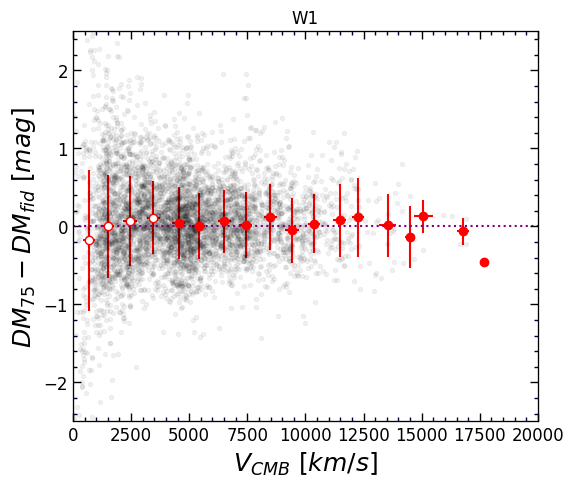

In [34]:
dff['dDM'] = M1_fid - dff.M1_75.values

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values

ax.plot(X, Y, 'k.', alpha=0.05)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)


ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("W1")


In [35]:
np.mean(Y[X>4000])

0.055275072655603864

Text(0.5, 1.0, 'W1')

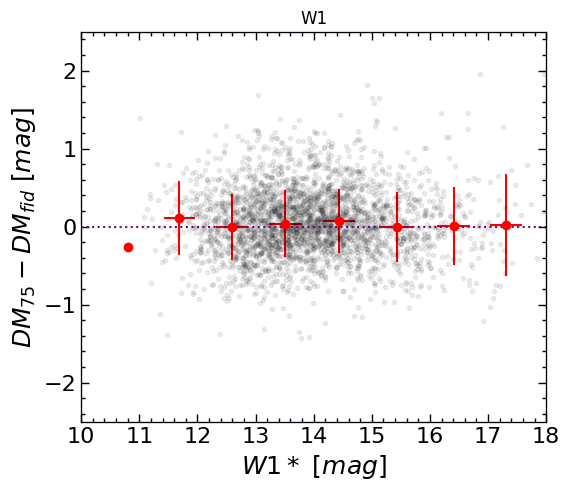

In [36]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff_ = dff[dff.V3k>4000]

X = dff_['w1***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("W1")

In [37]:
np.mean(Y)

0.055275072655603864

In [38]:
dff['DM1_fid'] = dff["w1***"] - M1_fid

<ipython-input-38-582f1980af7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DM1_fid'] = dff["w1***"] - M1_fid


<ipython-input-39-562717bd3820>:7: RuntimeWarning: invalid value encountered in log10
  Y = np.log10(dff.Vmod.values)-(dff.DM1_fid.values-25)/5.
<ipython-input-39-562717bd3820>:10: RuntimeWarning: invalid value encountered in less
  X = X[np.abs(Y0)<2]
<ipython-input-39-562717bd3820>:11: RuntimeWarning: invalid value encountered in less
  Y = Y[np.abs(Y0)<2]


(76.0670436965693, 6.053137953237307)

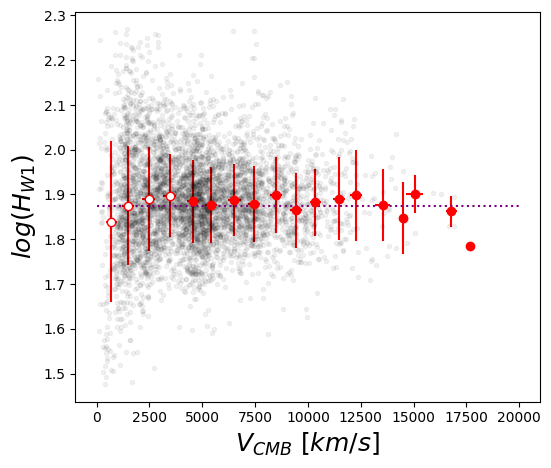

In [39]:

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = np.log10(dff.Vmod.values)-(dff.DM1_fid.values-25)/5.

Y0 = dff.dDM.values
X = X[np.abs(Y0)<2]
Y = Y[np.abs(Y0)<2]



# X = X[np.abs(Y)<2]
# Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{CMB} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log(H_{W1})$', fontsize=18)

Hfid = np.log10(75)
ax.plot([0,20000], [Hfid,Hfid], ':', color='purple')

m = np.median(Y[X>4000])
H0 = 10**m
H0e = np.log(10.)*H0*(m/np.sqrt(len(Y[X>4000])))

H0, H0e

In [40]:
dff.columns

Index(['flag', 'DM_av', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'PGC1', 'Nest',
       'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel', 'Vls', 'V3k', 'f',
       'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc', 'g***', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE', 'GLong', 'GLat', 'SGL', 'SGB',
       'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg', 'Vlsg', 'V3kg', 'fg', 'Vmod',
       'D75', 'logD75', 'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75',
       'gi', 'F', 'e_F', 'Flux', 'F21_av', 'Ms_W1', 'logMs_i', 'Ms_i',
       'Mass_HI', 'logMs_av', 'Mgass', 'Mb', 'fraction', 'dDM', 'DM1_fid'],
      dtype='object')

In [41]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Ms_W1'] = 10**(gamma - 0.4*dff.M1_75)
dff['Mb'] = dff.Ms_W1 + 1.33*(10**(np.log10(dff.Mass_HI)))
dff['logMb'] = np.log10(dff.Mb.values)

dff[['DM_75', 'DM1_fid', 'Mass_HI', 'Ms_W1', 'Mb', 'F21', 'eF21', 'Qw']].to_csv("BTFR_W1_distances_noCorrection.csv")

<ipython-input-41-49114314bd1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
<ipython-input-41-49114314bd1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Ms_W1'] = 10**(gamma - 0.4*dff.M1_75)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-41-49114314bd1b>:3: SettingWithCopyWarning: 
A value

<ipython-input-42-fe2f5407d793>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
<ipython-input-42-fe2f5407d793>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Ms_W1'] = 10**(gamma - 0.4*dff.M1_75)
<ipython-input-42-fe2f5407d793>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

(3.31688912524737, 10.320280407985637)

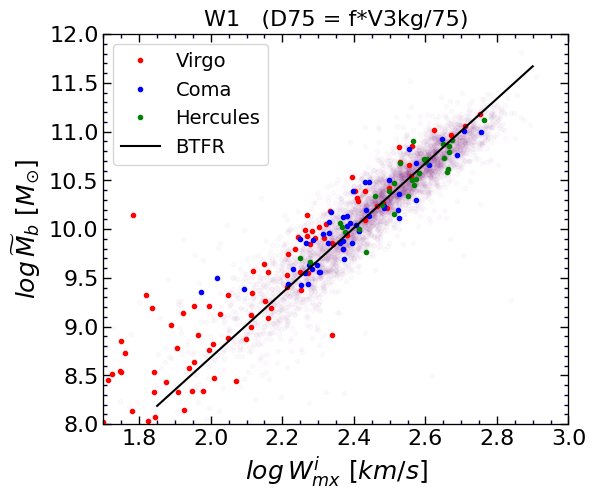

In [42]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Ms_W1'] = 10**(gamma - 0.4*dff.M1_75)
dff['Mb'] = dff.Ms_W1 + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='purple', alpha=0.02) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("W1   (D75 = f*V3kg/75)", fontsize=16)


w = np.linspace(1.85, 2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [43]:
len(dff)

5182